In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/gdrive')
import numpy as np

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


o	indegree: Number of incoming transactions.

o	outdegree: Number of outgoing transactions.

o	in_btc: Total bitcoins received.

o	out_btc: Total bitcoins sent.

o	total_btc: Net bitcoins.

o	mean_in_btc: Average bitcoins received.

o	mean_out_btc: Average bitcoins sent.


#Import Libraries


In [ ]:
!pip install shap

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split,KFold
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report,roc_auc_score,confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import numpy as np
from keras.models import Model, Sequential
from keras.layers import Dense, Input
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import xgboost as xgb
from xgboost import XGBClassifier
import random
from sklearn.datasets import make_classification # Import the make_classification function
from imblearn.over_sampling import ADASYN
import shap
from imblearn.under_sampling import NearMiss
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, f1_score

In [ ]:
data = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/FYP/data/data.csv')

In [ ]:
data.size

82017

#Preprocessing

In [ ]:
data.head()

,tx_hash,indegree,outdegree,in_btc,out_btc,total_btc,mean_in_btc,mean_out_btc,in_malicious,out_malicious,is_malicious,out_and_tx_malicious,all_malicious
0,5960ef23078b27e2df1bbc85aad03e992ff2954a389aff...,0,1,0.00,50.00,50.00,0.000000,50.000,1,0,0,0,1
1,4885ddf124a0f97b5a3775a12de0274d342d12842ebe59...,478,2,25000.62,25000.01,50000.63,52.302552,12500.005,0,0,1,1,1
2,728687e622ac7e62fae81dfda0c10051ee5c2fd49e80ed...,0,1,0.00,50.00,50.00,0.000000,50.000,0,0,0,0,0
3,75c2b884369bb80700bf33cf3c628b3f76382aa9ea2160...,0,1,0.00,50.00,50.00,0.000000,50.000,1,0,0,0,1
4,83e5ce9f7c1760fce5ab26b89e2e9b636b28c03ad72dbe...,0,1,0.00,50.00,50.00,0.000000,50.000,0,0,0,0,0


In [ ]:
data.drop('tx_hash', axis=1, inplace=True)

Class 0: 6205
Class 1: 104
Total: 6309


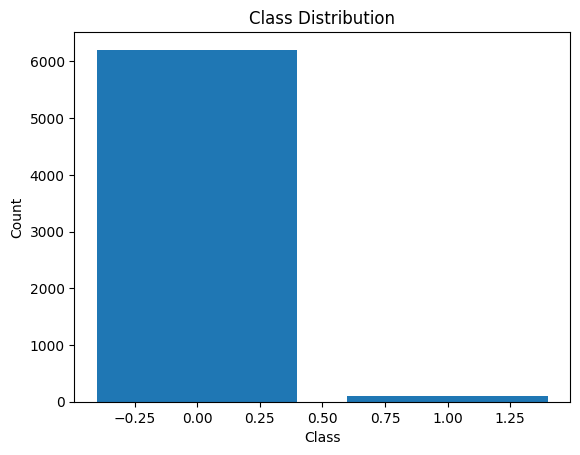

In [ ]:
# prompt: check class distribution

target_count = data['out_and_tx_malicious'].value_counts()

print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Total:', target_count.sum())

# Visualize the class distribution using a bar chart
plt.bar(target_count.index, target_count.values)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

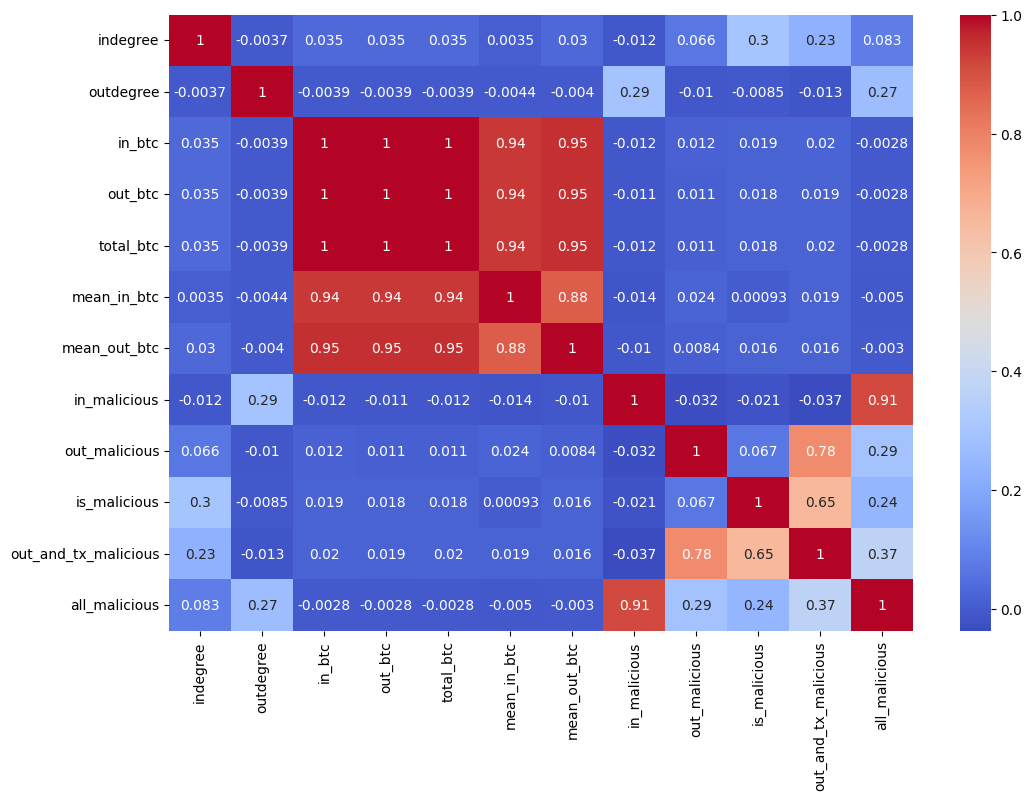

In [ ]:
# prompt: hwatmap visualization. it is not clear. define plot size. values not clear

plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm")
plt.show()


In [ ]:
# prompt: calculate p-value t-value. not add result to the datafarame. not clear output. thisplay in table


# Calculate p-value and t-value for each column
p_values = []
t_values = []
for col in data.columns:
  stat, pval = stats.ttest_1samp(data[col], 0)
  p_values.append(pval)
  t_values.append(stat)

# Create a table to display the results
table = pd.DataFrame({
  'Column': data.columns,
  'p-value': p_values,
  't-value': t_values
})

# Display the table without clearing the output
print(table.to_string())



                  Column        p-value    t-value
0               indegree   2.049637e-46  14.421919
1              outdegree   1.314379e-44  14.122422
2                 in_btc   1.126817e-03   3.258284
3                out_btc   1.040960e-03   3.280744
4              total_btc   1.083029e-03   3.269533
5            mean_in_btc   4.861588e-05   4.065003
6           mean_out_btc   2.125214e-03   3.073424
7           in_malicious  8.823751e-135  25.318836
8          out_malicious   1.773592e-15   7.976551
9           is_malicious   1.824575e-11   6.731723
10  out_and_tx_malicious   1.322867e-24  10.282332
11         all_malicious  1.124500e-159  27.718420


In [ ]:
data.drop('in_malicious', axis=1, inplace=True)
data.drop('out_malicious', axis=1, inplace=True)
data.drop('is_malicious', axis=1, inplace=True)
data.drop('all_malicious', axis=1, inplace=True)
data.drop('out_btc', axis=1, inplace=True)


# Without Balancing


In [ ]:
data_copy = data.copy()
features = data_copy.drop(columns=['out_and_tx_malicious'])
target = data_copy['out_and_tx_malicious']

# Convert dataframe to numpy arrays
X = features.values
y = target.values

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# prompt: train Decision tree GBoost RF Adaboost

# Train Decision Tree
dt_model = DecisionTreeClassifier()
dt_model.fit(X_balanced, y_balanced)

# Train Gradient Boosting
gb_model = xgb.XGBClassifier()
gb_model.fit(X_balanced, y_balanced)

# Train Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_balanced, y_balanced)

# Train AdaBoost
ada_model = AdaBoostClassifier()
ada_model.fit(X_balanced, y_balanced)



AdaBoostClassifier()

In [ ]:
# prompt: false positive rate

# Calculate the false positive rate for each model
dt_fpr = confusion_matrix(y_test, dt_model.predict(X_test))[0, 1] / confusion_matrix(y_test, dt_model.predict(X_test))[0, 0]
gb_fpr = confusion_matrix(y_test, gb_model.predict(X_test))[0, 1] / confusion_matrix(y_test, gb_model.predict(X_test))[0, 0]
rf_fpr = confusion_matrix(y_test, rf_model.predict(X_test))[0, 1] / confusion_matrix(y_test, rf_model.predict(X_test))[0, 0]
ada_fpr = confusion_matrix(y_test, ada_model.predict(X_test))[0, 1] / confusion_matrix(y_test, ada_model.predict(X_test))[0, 0]

# Print the false positive rate for each model
print("Decision Tree False Positive Rate:", dt_fpr)
print("Gradient Boosting False Positive Rate:", gb_fpr)
print("Random Forest False Positive Rate:", rf_fpr)
print("AdaBoost False Positive Rate:", ada_fpr)


Decision Tree False Positive Rate: 0.3804226918798665
Gradient Boosting False Positive Rate: 0.28868120456905505
Random Forest False Positive Rate: 0.33297529538131043
AdaBoost False Positive Rate: 0.0


In [ ]:
# prompt: get prediction

# Predict using Decision Tree
y_pred_dt = dt_model.predict(X_test)

# Predict using Gradient Boosting
y_pred_gb = gb_model.predict(X_test)

# Predict using Random Forest
y_pred_rf = rf_model.predict(X_test)

# Predict using AdaBoost
y_pred_ada = ada_model.predict(X_test)



In [ ]:
# prompt: evaluate models

# Print accuracy scores
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Gradient Boosting Accuracy:", accuracy_score(y_test, y_pred_gb))
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("AdaBoost Accuracy:", accuracy_score(y_test, y_pred_ada))

# Print classification reports
print("Decision Tree Report:\n", classification_report(y_test, y_pred_dt))
print("Gradient Boosting Report:\n", classification_report(y_test, y_pred_gb))
print("Random Forest Report:\n", classification_report(y_test, y_pred_rf))
print("AdaBoost Report:\n", classification_report(y_test, y_pred_ada))

# Print ROC AUC scores
print("Decision Tree ROC AUC:", roc_auc_score(y_test, y_pred_dt))
print("Gradient Boosting ROC AUC:", roc_auc_score(y_test, y_pred_gb))
print("Random Forest ROC AUC:", roc_auc_score(y_test, y_pred_rf))
print("AdaBoost ROC AUC:", roc_auc_score(y_test, y_pred_ada))


Decision Tree Accuracy: 0.713946117274168
Gradient Boosting Accuracy: 0.7717908082408875
Random Forest Accuracy: 0.7472266244057052
AdaBoost Accuracy: 0.9833597464342314
Decision Tree Report:
               precision    recall  f1-score   support

           0       0.98      0.72      0.83      1241
           1       0.01      0.10      0.01        21

    accuracy                           0.71      1262
   macro avg       0.49      0.41      0.42      1262
weighted avg       0.96      0.71      0.82      1262

Gradient Boosting Report:
               precision    recall  f1-score   support

           0       0.99      0.78      0.87      1241
           1       0.04      0.52      0.07        21

    accuracy                           0.77      1262
   macro avg       0.51      0.65      0.47      1262
weighted avg       0.97      0.77      0.86      1262

Random Forest Report:
               precision    recall  f1-score   support

           0       0.99      0.75      0.85     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(ada_model, X_train, y_train, cv=cv, scoring='accuracy')

print("Cross-validation results for Stacking Classifier:")
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")


Cross-validation results for Stacking Classifier:
Cross-validation scores: [0.98811881 0.98019802 0.97819623 0.98711596 0.98810704]
Mean cross-validation score: 0.9843472117281105


In [ ]:
# Define the cross-validation configuration
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# List of models
models = [dt_model, gb_model, rf_model, ada_model]
model_names = ['Decision Tree', 'Gradient Boosting', 'Random Forest', 'AdaBoost']

# Iterate through each model and perform cross-validation
for model, name in zip(models, model_names):
    cv_scores = cross_val_score(model, X_balanced, y_balanced, cv=cv, scoring='accuracy')
    print(f"Cross-validation results for {name}:")
    print(f"Cross-validation scores: {cv_scores}")
    print(f"Mean cross-validation score: {cv_scores.mean()}")
    print('-'*50)

Cross-validation results for Decision Tree:
Cross-validation scores: [0.856      0.832      0.776      0.904      0.81451613]
Mean cross-validation score: 0.8365032258064516
--------------------------------------------------
Cross-validation results for Gradient Boosting:
Cross-validation scores: [0.888      0.864      0.84       0.896      0.80645161]
Mean cross-validation score: 0.8588903225806451
--------------------------------------------------
Cross-validation results for Random Forest:
Cross-validation scores: [0.848      0.856      0.824      0.936      0.81451613]
Mean cross-validation score: 0.8557032258064516
--------------------------------------------------
Cross-validation results for AdaBoost:
Cross-validation scores: [0.856      0.888      0.896      0.936      0.82258065]
Mean cross-validation score: 0.8797161290322582
--------------------------------------------------


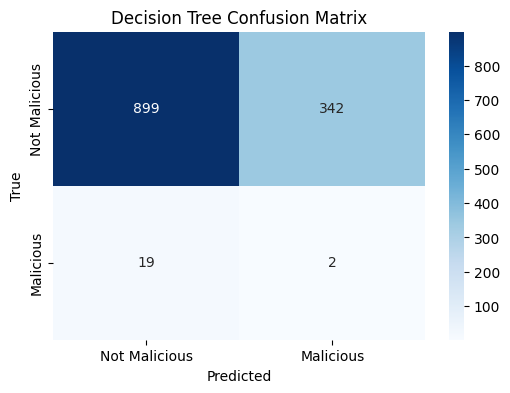

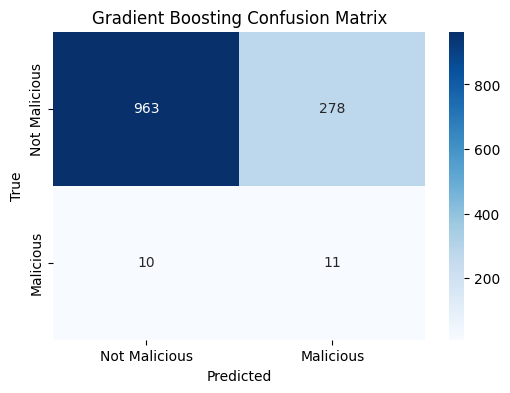

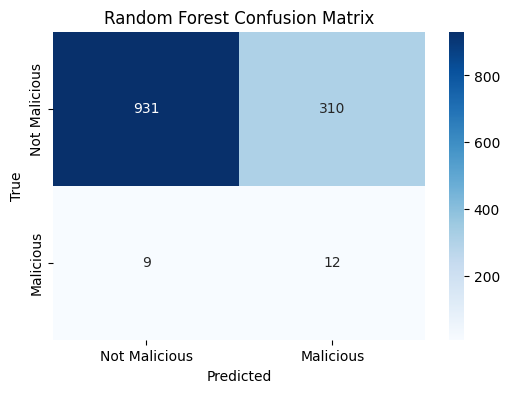

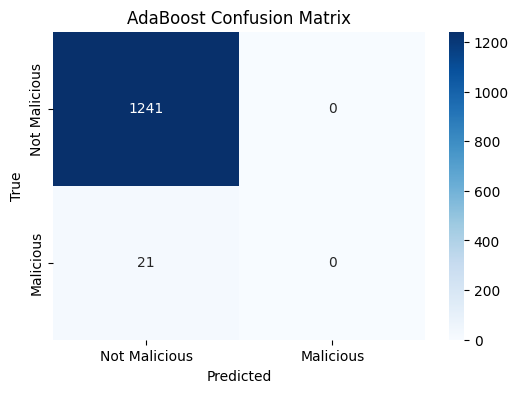

In [ ]:
# prompt: confusion matrix visualization

# Create confusion matrix for Decision Tree
cm_dt = confusion_matrix(y_test, y_pred_dt)

# Create confusion matrix for Gradient Boosting
cm_gb = confusion_matrix(y_test, y_pred_gb)

# Create confusion matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Create confusion matrix for AdaBoost
cm_ada = confusion_matrix(y_test, y_pred_ada)

# Define labels for the axes
labels = ['Not Malicious', 'Malicious']

# Plot confusion matrix for Decision Tree
plt.figure(figsize=(6, 4))
sns.heatmap(cm_dt, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Decision Tree Confusion Matrix")
plt.show()

# Plot confusion matrix for Gradient Boosting
plt.figure(figsize=(6, 4))
sns.heatmap(cm_gb, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Gradient Boosting Confusion Matrix")
plt.show()

# Plot confusion matrix for Random Forest
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Random Forest Confusion Matrix")
plt.show()

# Plot confusion matrix for AdaBoost
plt.figure(figsize=(6, 4))
sns.heatmap(cm_ada, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("AdaBoost Confusion Matrix")
plt.show()


#Transformation

          indegree    outdegree         in_btc      total_btc    mean_in_btc  \
count  6309.000000  6309.000000    6309.000000    6309.000000    6309.000000   
mean      1.854969     4.203677     576.153395    1156.225852     224.944712   
std      10.216306    23.642883   14045.249935   28089.061151    4395.367768   
min       0.000000     0.000000       0.000000       0.000150       0.000000   
25%       1.000000     2.000000       0.136990       1.795103       0.090175   
50%       1.000000     2.000000       3.090047      20.000000       2.414427   
75%       1.000000     2.000000      27.882500      55.210225      23.001000   
max     478.000000   764.000000  456068.702373  912137.404746  227428.520663   

        mean_out_btc  
count    6309.000000  
mean      332.641125  
std      8596.739987  
min         0.000000  
25%         0.420092  
50%         4.855000  
75%        40.800000  
max    454687.872560  


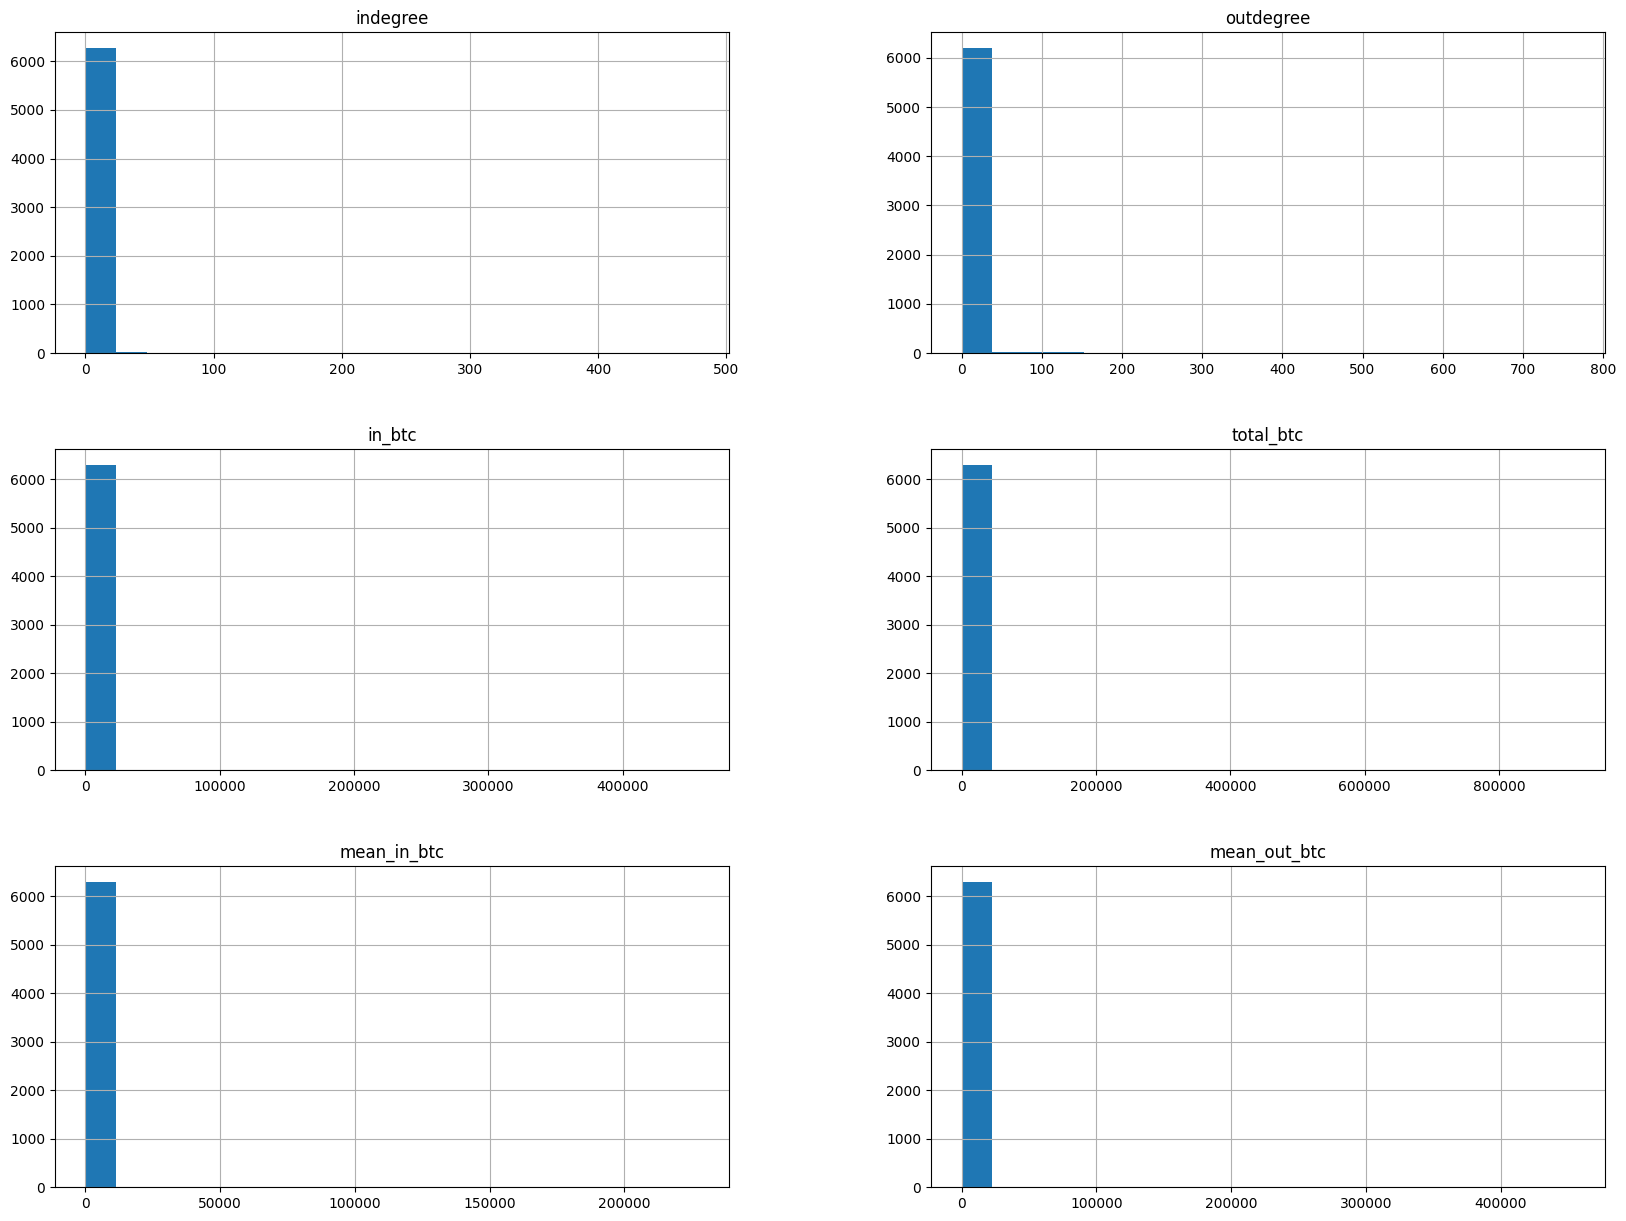

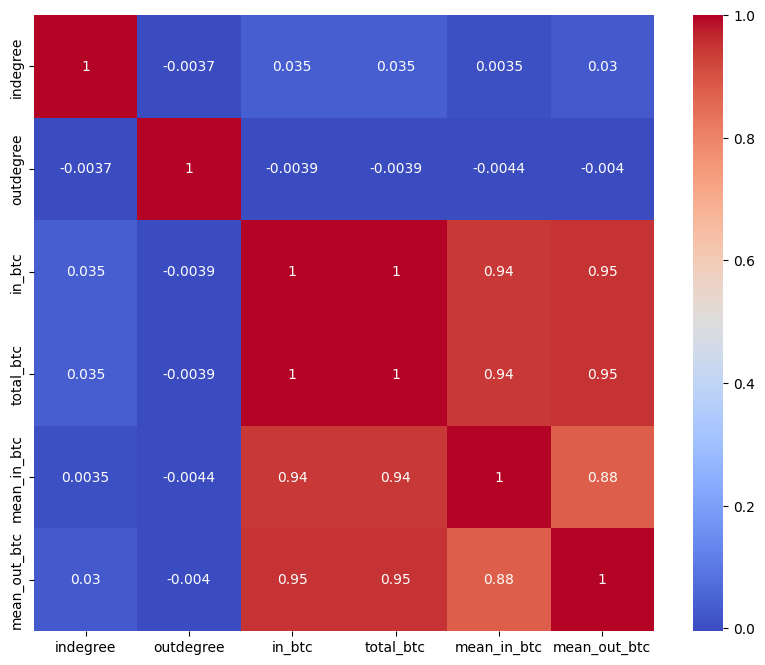

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Separate features and target
X = data.drop('out_and_tx_malicious', axis=1)
y = data['out_and_tx_malicious']

# Summary statistics
summary_stats = X.describe()
print(summary_stats)

# Visual inspection
X.hist(bins=20, figsize=(20, 15))
plt.show()

# Correlation matrix
correlation_matrix = X.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()


In [ ]:
# # prompt: check skeweness visualization for all columns (indegree,outdegree,in_btc,total_btc,mean_in_btc,mean_out_btc)

# import matplotlib.pyplot as plt
# import seaborn as sns

# # Create a list of numeric columns
# numeric_columns = ['indegree', 'outdegree', 'in_btc', 'total_btc', 'mean_in_btc', 'mean_out_btc']

# # Iterate through each column and plot the skewness visualization
# for col in numeric_columns:
#     plt.figure(figsize=(6, 2))
#     plt.subplot(1, 2, 1)
#     sns.histplot(data[col], kde=True)
#     plt.title(f'Histogram of {col}')
#     plt.xlabel(col)

#     plt.subplot(1, 2, 2)
#     stats.probplot(data[col], dist="norm", plot=plt)
#     plt.title(f'QQ Plot of {col}')
#     plt.show()



In [ ]:
# Log scale to normalize the data
scaled_df = data.copy()

scaled_df['indegree'] = np.log1p(scaled_df['indegree'])
scaled_df['outdegree']= np.log1p(scaled_df['outdegree'])
scaled_df['in_btc'] = np.log1p(scaled_df['in_btc'])
scaled_df['total_btc']= np.log1p(scaled_df['total_btc'])
scaled_df['mean_in_btc']= np.log1p(scaled_df['mean_in_btc'])
scaled_df['mean_out_btc']= np.log1p(scaled_df['mean_out_btc'])

# RobustScaler is less prone to outliers.
from sklearn.preprocessing import RobustScaler
rob_scaler = RobustScaler()

scaled_df['indegree'] = rob_scaler.fit_transform(scaled_df['indegree'].values.reshape(-1,1))
scaled_df['outdegree'] = rob_scaler.fit_transform(scaled_df['outdegree'].values.reshape(-1,1))
scaled_df['in_btc'] = rob_scaler.fit_transform(scaled_df['in_btc'].values.reshape(-1,1))
scaled_df['total_btc'] = rob_scaler.fit_transform(scaled_df['total_btc'].values.reshape(-1,1))
scaled_df['mean_in_btc'] = rob_scaler.fit_transform(scaled_df['mean_in_btc'].values.reshape(-1,1))
scaled_df['mean_out_btc'] = rob_scaler.fit_transform(scaled_df['mean_out_btc'].values.reshape(-1,1))

In [ ]:
scaled_df.head()

,indegree,outdegree,in_btc,total_btc,mean_in_btc,mean_out_btc,out_and_tx_malicious
0,-0.693147,-0.405465,-0.435432,0.295647,-0.397188,0.639982,0
1,5.478553,0.000000,2.695066,2.590701,0.888807,2.266668,1
2,-0.693147,-0.405465,-0.435432,0.295647,-0.397188,0.639982,0
3,-0.693147,-0.405465,-0.435432,0.295647,-0.397188,0.639982,0
4,-0.693147,-0.405465,-0.435432,0.295647,-0.397188,0.639982,0


# Train/Test Split

In [ ]:
# Separate features and target
features = scaled_df.drop('out_and_tx_malicious', axis=1)
target = scaled_df['out_and_tx_malicious']


# Convert dataframe to numpy arrays
X = features.values
y = target.values
# Split the data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Step 1: Split  data into training and temporary (validation + test) sets
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Further split the temporary set into validation and test sets
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.25, random_state=42)

# - X_train, y_train: Training set (60% of the original data)
# - X_val, y_val: Validation set (20% of the original data)
# - X_test, y_test: Test set (20% of the original data)

In [ ]:
print(features)

      indegree  outdegree    in_btc  total_btc  mean_in_btc  mean_out_btc
0    -0.693147  -0.405465 -0.435432   0.295647    -0.397188      0.639982
1     5.478553   0.000000  2.695066   2.590701     0.888807      2.266668
2    -0.693147  -0.405465 -0.435432   0.295647    -0.397188      0.639982
3    -0.693147  -0.405465 -0.435432   0.295647    -0.397188      0.639982
4    -0.693147  -0.405465 -0.435432   0.295647    -0.397188      0.639982
...        ...        ...       ...        ...          ...           ...
6304  0.916291   0.000000  2.411822   2.285402     2.133556      1.995786
6305  0.916291   0.000000  2.039707   1.884282     1.744445      1.639949
6306  1.386294   0.000000  2.634542   2.525468     2.185579      2.208790
6307  1.252763   0.000000  1.914416   1.749210     1.482695      1.520165
6308  4.564348   0.000000  1.914266   1.749048     0.391814      1.520019

[6309 rows x 6 columns]


#UnderSampling

##Random Under Sampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

# Define the undersampling method
rus = RandomUnderSampler(sampling_strategy='majority')

# Resample the training data
X_balanced, y_balanced = rus.fit_resample(X_train, y_train)


##Near-Miss 1

In [ ]:
# prompt: give near miss 1 implementation

# Define the undersampling method
nm1 = NearMiss(version=1)

# Resample the training data
X_balanced, y_balanced = nm1.fit_resample(X_train, y_train)



##Near - Miss -2


In [ ]:
# prompt: Near miss 2

# Define the undersampling method
nm2 = NearMiss(version=2)

# Resample the training data
X__balanced, y__balanced = nm2.fit_resample(X_train, y_train)

Class distribution after undersampling: out_and_tx_malicious
0    0.5
1    0.5
Name: proportion, dtype: float64


## Near Miss -3

In [ ]:
# prompt: near miss 3

# Define the undersampling method
nm3 = NearMiss(version=3)

# Resample the training data
X_balanced, y_balanced = nm3.fit_resample(X_train, y_train)

##XGBCLUS

In [ ]:
# Number of positive samples
P = np.sum(y_train == 1)

# Number of iterations
k = 100

import numpy as np
from sklearn.metrics import confusion_matrix
import xgboost as xgb

def XGBCLUS(X_train, y_train, X_test, y_test, P, k):
    TMAX = 0
    FMIN = float('inf')
    Selected_Samples = []

    for _ in range(k):
        neg_indices = np.where(y_train == 0)[0]
        pos_indices = np.where(y_train == 1)[0]
        selected_neg_indices = np.random.choice(neg_indices, P, replace=False)

        selected_indices = np.concatenate([selected_neg_indices, pos_indices])
        np.random.shuffle(selected_indices)

        X_train_selected = X_train[selected_indices]
        y_train_selected = y_train[selected_indices]

        model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
        model.fit(X_train_selected, y_train_selected)

        y_pred = model.predict(X_test)

        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        if tp > TMAX and fp < FMIN:
            TMAX = tp
            FMIN = fp
            Selected_Samples = selected_indices.tolist()

    if not Selected_Samples:
        print("No samples selected, reinitializing TMAX and FMIN")
        return XGBCLUS(X_train, y_train, X_test, y_test, P, k)

    return X_train[Selected_Samples], y_train[Selected_Samples]

# Run the algorithm
X_balanced, y_balanced = XGBCLUS(X_train, y_train, X_test, y_test, P, k)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:04:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:04:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:04:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:04:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:04:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

#OverSampling

## SMOTE

In [ ]:
# prompt: smote

sm = SMOTE(random_state=42)

# Resample the training data
X_balanced, y_balanced = sm.fit_resample(X_train, y_train)

## ADAYASN

In [ ]:
# prompt: Adaysn
ada = ADASYN(random_state=42)

# Resample the training data
X_balanced, y_balanced = ada.fit_resample(X_train, y_train)

#HyBrid


##SMOTEENN

In [ ]:
# prompt: SMOTEENN
smote_enn = SMOTEENN(random_state=42)

# Resample the training data
X__balanced, y_balanced = smote_enn.fit_resample(X_train, y_train)



##SMOTETOMEK

In [ ]:
# prompt: Smottomek

smote_tomek = SMOTETomek(random_state=42)

# Resample the training data
X_balanced, y_balanced = smote_tomek.fit_resample(X_train, y_train)



##New Approach

In [ ]:
X = scaled_df.drop(columns=['out_and_tx_malicious'])  # Exclude the 'out_and_tx_malicious' column
y = scaled_df['out_and_tx_malicious']  # Select only the 'out_and_tx_malicious' column as target


original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.20, random_state=10)

In [ ]:
from sklearn.utils import shuffle

original_train_df = pd.concat([original_Xtrain, original_ytrain], axis=1)
original_train_normal_df = original_train_df[original_train_df.out_and_tx_malicious == 0]
original_train_fraud_df = original_train_df[original_train_df.out_and_tx_malicious == 1]

def get_training_sample(n):
    normal_sample = original_train_normal_df.sample(n)
    final_sample = pd.concat([normal_sample, original_train_fraud_df])
    final_sample = shuffle(final_sample)

    return final_sample.iloc[:,:-1].values, final_sample.iloc[:,-1].values

In [ ]:
original_test_df = pd.concat([original_Xtest, original_ytest], axis=1)
original_test_normal_df = original_test_df[original_test_df.out_and_tx_malicious == 0]
original_test_fraud_df = original_test_df[original_test_df.out_and_tx_malicious == 1]

def get_test_sample(n):
    normal_sample = original_test_normal_df.sample(n)
    final_sample = pd.concat([normal_sample, original_test_fraud_df])
    final_sample = shuffle(final_sample)
    return final_sample.iloc[:,:-1].values, final_sample.iloc[:,-1].values

In [ ]:
from imblearn.over_sampling import SMOTE

def oversample_minority_class(X, y, fraction):
    SM = SMOTE(sampling_strategy=fraction, n_jobs=-1)
    return SM.fit_resample(X, y)


In [ ]:
oversampling_fraction = 0.240
training_sample_size = int(len(original_ytrain) / 10)
testing_sample_size = int(len(original_ytrain) / 10)


sample_Xtrain, sample_ytrain = get_training_sample(training_sample_size)
X_balanced, y_balanced = oversample_minority_class(sample_Xtrain, sample_ytrain, oversampling_fraction)

sample_Xtset, sample_ytest = get_test_sample(testing_sample_size)
X_test, y_test = oversample_minority_class(sample_Xtset, sample_ytest, oversampling_fraction)


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


# Stacking Classifier

In [ ]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin, clone

class StackingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_models, meta_model):
        self.base_models = base_models
        self.meta_model = meta_model

    def fit(self, X, y):
        self.base_models_ = [list() for _ in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))

        for i, model in enumerate(self.base_models):
            for train_idx, holdout_idx in KFold(n_splits=5).split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_idx], y[train_idx])
                y_pred = instance.predict(X[holdout_idx])
                out_of_fold_predictions[holdout_idx, i] = y_pred

        self.meta_model_.fit(out_of_fold_predictions, y)
        return self

    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_
        ])
        return self.meta_model_.predict(meta_features)



# Define base models and meta model
base_models = [RandomForestClassifier(), GradientBoostingClassifier(), AdaBoostClassifier(), DecisionTreeClassifier()]
meta_model = LogisticRegression()

# Initialize  stacking classifier
stacking_clf = StackingClassifier(base_models=base_models, meta_model=meta_model)

In [ ]:
# Cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(stacking_clf, X_balanced, y_balanced, cv=cv, scoring='accuracy')

print("Cross-validation results for Stacking Classifier:")
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")


Cross-validation results for Stacking Classifier:
Cross-validation scores: [0.856      0.88       0.856      0.928      0.80645161]
Mean cross-validation score: 0.8652903225806451


In [ ]:
stacking_clf.fit(X_balanced, y_balanced)
y_pred_train = stacking_clf.predict(X_balanced)
y_pred_test = stacking_clf.predict(X_test)

In [ ]:
# Calculate and print training accuracy and confusion matrix for hard voting classifier
train_accuracy = accuracy_score(y_balanced, y_pred_train)
print(f"Stacking Classifier Training Accuracy: {train_accuracy}")
conf_matrix_train = confusion_matrix(y_balanced, y_pred_train)
print("Confusion Matrix  - Training Data:")
print(conf_matrix_train)


# Print classification report
print(classification_report(y_balanced, y_pred_train))

Stacking Classifier Training Accuracy: 0.9294871794871795
Confusion Matrix  - Training Data:
[[502   2]
 [ 42  78]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       504
           1       0.97      0.65      0.78       120

    accuracy                           0.93       624
   macro avg       0.95      0.82      0.87       624
weighted avg       0.93      0.93      0.92       624



In [ ]:
# Calculate and print test accuracy and confusion matrix for hard voting classifier
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Stacking Classifier Test Accuracy: {test_accuracy}")
conf_matrix_hard_test = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix  - Test Data:")
print(conf_matrix_hard_test)

print(classification_report(y_test, y_pred_test))

Stacking Classifier Test Accuracy: 0.9564183835182251
Confusion Matrix  - Test Data:
[[1207   34]
 [  21    0]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1241
           1       0.00      0.00      0.00        21

    accuracy                           0.96      1262
   macro avg       0.49      0.49      0.49      1262
weighted avg       0.97      0.96      0.96      1262



In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

# Extract the number of true negatives (TN) and false positives (FP)
tn, fp, fn, tp = cm.ravel()

# Calculate the false positive rate
fpr = fp / (fp + tn)

# Print the false positive rate
print(f"testing False positive rate(staking- RUC): {fpr}")


testing False positive rate(staking- RUC): 0.0273972602739726


In [ ]:
# prompt: give area under cureve accuracy

# Calculate ROC AUC score for Stacking Classifier
roc_auc = roc_auc_score(y_test, y_pred_test)

# Print ROC AUC score
print(f"Stacking Classifier ROC AUC: {roc_auc}")


Stacking Classifier ROC AUC: 0.4863013698630137


#Voting Classifier

In [ ]:
# Define individual models
model1 = DecisionTreeClassifier(random_state=42)
model2 = XGBClassifier(random_state=42)
model3 = GradientBoostingClassifier(random_state=42)
model4 = RandomForestClassifier(random_state=42)
model5 = AdaBoostClassifier(random_state=42)


### Hard Voting

In [ ]:
# Initialize Voting Classifier with hard voting
voting_clf_hard = VotingClassifier(estimators=[
    ('dt', model1), ('xgb', model2), ('gb', model3), ('rf', model4), ('adb', model5)], voting='hard')

In [ ]:
# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation for hard voting classifier
cv_scores_hard = cross_val_score(voting_clf_hard, X_balanced, y_balanced, cv=cv, scoring='accuracy')

print("Cross-validation results for Hard Voting Classifier:")
print(f"Cross-validation scores: {cv_scores_hard}")
print(f"Mean cross-validation score: {cv_scores_hard.mean()}")

Cross-validation results for Hard Voting Classifier:
Cross-validation scores: [0.848      0.88       0.888      0.848      0.87903226]
Mean cross-validation score: 0.8686064516129033


In [ ]:
# Train and evaluate hard voting classifier
voting_clf_hard.fit(X_balanced, y_balanced)
y_pred_hard_train = voting_clf_hard.predict(X_balanced)
y_pred_hard_test = voting_clf_hard.predict(X_test)

In [ ]:
# Calculate and print training accuracy and confusion matrix for soft voting classifier
train_accuracy_Hard = accuracy_score(y_balanced, y_pred_hard_train)
print(f"Voting Classifier (Hard) Training Accuracy: {train_accuracy_Hard}")
conf_matrix_Hard_train = confusion_matrix(y_balanced, y_pred_hard_train)
print("Confusion Matrix (Hard Voting) - Training Data:")
print(conf_matrix_Hard_train)


# Print classification report
print(classification_report(y_balanced, y_pred_hard_train))

Voting Classifier (Hard) Training Accuracy: 0.9903846153846154
Confusion Matrix (Hard Voting) - Training Data:
[[503   1]
 [  5 115]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       504
           1       0.99      0.96      0.97       120

    accuracy                           0.99       624
   macro avg       0.99      0.98      0.98       624
weighted avg       0.99      0.99      0.99       624



In [ ]:
# Calculate and print test accuracy and confusion matrix for hard voting classifier
test_accuracy_hard = accuracy_score(y_test, y_pred_hard_test)
print(f"Voting Classifier (Hard) Test Accuracy: {test_accuracy_hard}")
conf_matrix_hard_test = confusion_matrix(y_test, y_pred_hard_test)
print("Confusion Matrix (Hard Voting) - Test Data:")
print(conf_matrix_hard_test)

print(classification_report(y_test, y_pred_hard_test))

Voting Classifier (Hard) Test Accuracy: 0.8486529318541997
Confusion Matrix (Hard Voting) - Test Data:
[[1069  172]
 [  19    2]]
              precision    recall  f1-score   support

           0       0.98      0.86      0.92      1241
           1       0.01      0.10      0.02        21

    accuracy                           0.85      1262
   macro avg       0.50      0.48      0.47      1262
weighted avg       0.97      0.85      0.90      1262



In [ ]:
# prompt: FPR

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_hard_test)

# Extract the number of true negatives (TN) and false positives (FP)
tn, fp, fn, tp = cm.ravel()

# Calculate the false positive rate
fpr = fp / (fp + tn)

# Print the false positive rate
print(f"False positive rate-RUC(hard): {fpr}")


False positive rate-RUC(hard): 0.1385979049153908


In [ ]:
# prompt: give area under cureve accuracy

# Calculate ROC AUC score for Stacking Classifier
roc_auc = roc_auc_score(y_test, y_pred_test)

# Print ROC AUC score
print(f"Stacking Classifier ROC AUC: {roc_auc}")


Stacking Classifier ROC AUC: 0.4863013698630137


### Soft voting

In [ ]:
# Initialize Voting Classifier with soft voting
voting_clf_soft = VotingClassifier(estimators=[
    ('dt', model1), ('xgb', model2), ('gb', model3), ('rf', model4), ('adb', model5)], voting='soft')

In [ ]:
# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Cross-validation for soft voting classifier
cv_scores_soft = cross_val_score(voting_clf_soft, X_balanced, y_balanced, cv=cv, scoring='accuracy')

print("Cross-validation results for Soft Voting Classifier:")
print(f"Cross-validation scores: {cv_scores_soft}")
print(f"Mean cross-validation score: {cv_scores_soft.mean()}")

Cross-validation results for Soft Voting Classifier:
Cross-validation scores: [0.84       0.864      0.88       0.856      0.87903226]
Mean cross-validation score: 0.8638064516129033


In [ ]:
# Train and evaluate soft voting classifier
voting_clf_soft.fit(X_balanced, y_balanced)
y_pred_soft_train = voting_clf_soft.predict(X_balanced)
y_pred_soft_test = voting_clf_soft.predict(X_test)

In [ ]:
# Calculate and print training accuracy and confusion matrix for soft voting classifier
train_accuracy_soft = accuracy_score(y_balanced, y_pred_soft_train)
print(f"Voting Classifier (Soft) Training Accuracy: {train_accuracy_soft}")
conf_matrix_soft_train = confusion_matrix(y_balanced, y_pred_soft_train)
print("Confusion Matrix (Soft Voting) - Training Data:")
print(conf_matrix_soft_train)


# Print classification report
print(classification_report(y_balanced, y_pred_soft_train))

Voting Classifier (Soft) Training Accuracy: 0.9983974358974359
Confusion Matrix (Soft Voting) - Training Data:
[[504   0]
 [  1 119]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       504
           1       1.00      0.99      1.00       120

    accuracy                           1.00       624
   macro avg       1.00      1.00      1.00       624
weighted avg       1.00      1.00      1.00       624



In [ ]:
# Calculate and print test accuracy and confusion matrix for soft voting classifier
test_accuracy_soft = accuracy_score(y_test, y_pred_soft_test)
print(f"Voting Classifier (Soft) Test Accuracy: {test_accuracy_soft}")
conf_matrix_soft_test = confusion_matrix(y_test, y_pred_soft_test)
print("Confusion Matrix (Soft Voting) - Test Data:")
print(conf_matrix_soft_test)

print(classification_report(y_test, y_pred_soft_test))

Voting Classifier (Soft) Test Accuracy: 0.8288431061806656
Confusion Matrix (Soft Voting) - Test Data:
[[1044  197]
 [  19    2]]
              precision    recall  f1-score   support

           0       0.98      0.84      0.91      1241
           1       0.01      0.10      0.02        21

    accuracy                           0.83      1262
   macro avg       0.50      0.47      0.46      1262
weighted avg       0.97      0.83      0.89      1262



In [ ]:
# prompt: FPR

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_soft_test)

# Extract the number of true negatives (TN) and false positives (FP)
tn, fp, fn, tp = cm.ravel()

# Calculate the false positive rate
fpr = fp / (fp + tn)

# Print the false positive rate
print(f"False positive rate-RUC(hard): {fpr}")


False positive rate-RUC(hard): 0.1587429492344883


In [ ]:
# prompt: give area under cureve accuracy

# Calculate ROC AUC score for Stacking Classifier
roc_auc = roc_auc_score(y_test, y_pred_soft_test)

# Print ROC AUC score
print(f"Stacking Classifier ROC AUC: {roc_auc}")


Stacking Classifier ROC AUC: 0.46824757300180353


### feature Impotance

In [ ]:
# Extracting feature importances
def get_feature_importances(model, feature_names):
    importances = np.zeros(len(feature_names))
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = model.coef_[0]
    return importances

# Feature names
feature_names = features.columns  # or list of feature names
model1.fit(X_balanced, y_balanced)  # Fit the model
model2.fit(X_balanced, y_balanced)  # Fit the model
model3.fit(X_balanced, y_balanced)  # Fit the model
model4.fit(X_balanced, y_balanced)  # Fit the model
model5.fit(X_balanced, y_balanced)  # Fit the model

# Get importances from each model
importances_dt = get_feature_importances(model1, feature_names)
importances_xgb = get_feature_importances(model2, feature_names)
importances_gb = get_feature_importances(model3, feature_names)
importances_rf = get_feature_importances(model4, feature_names)
importances_adb = get_feature_importances(model5, feature_names)

# Aggregate feature importances
# Example: averaging the importances (weights can be adjusted based on model importance)
aggregate_importances = (importances_dt + importances_xgb + importances_gb + importances_rf+ importances_adb ) / 5

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': aggregate_importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)


        Feature  Importance
3     total_btc    0.272578
2        in_btc    0.235243
5  mean_out_btc    0.167136
4   mean_in_btc    0.130842
0      indegree    0.117162
1     outdegree    0.077039


#Explainable AI

##Train DT

In [ ]:
# Train a decision tree classifier
clf = DecisionTreeClassifier(max_depth=10, random_state=42)
clf.fit(X_balanced, y_balanced)


DecisionTreeClassifier(max_depth=10, random_state=42)

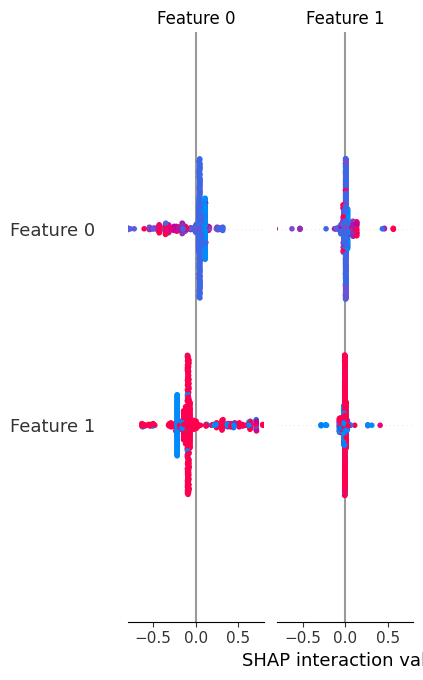

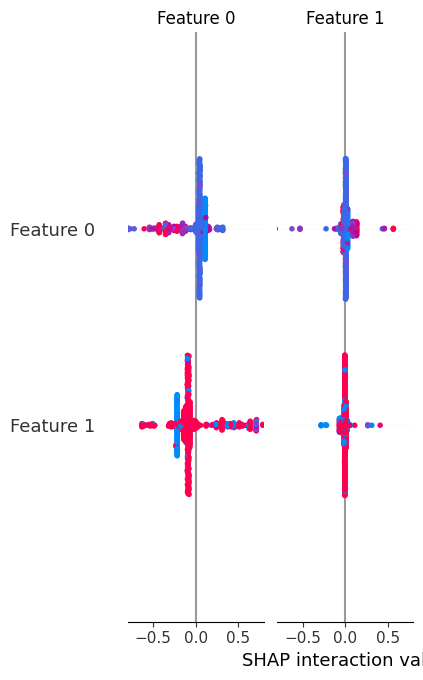

In [ ]:
import shap
import matplotlib.pyplot as plt

# Ensure that SHAP is correctly initialized
shap.initjs()

# Use the appropriate SHAP explainer for tree-based models
explainer = shap.TreeExplainer(clf)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test)

# If the model is for a binary classification, shap_values will be a list with two arrays
# We usually look at the SHAP values for the positive class (index 1)
if isinstance(shap_values, list):
    shap_values_to_plot = shap_values[1]
else:
    shap_values_to_plot = shap_values

# Generate a SHAP summary plot
shap.summary_plot(shap_values_to_plot, X_test, plot_type="bar")

# Additionally, you can also generate a regular SHAP summary plot to see individual feature impacts
shap.summary_plot(shap_values_to_plot, X_test)


#Anomoly Rule Generation

##Extract Decision Rules

In [ ]:
from sklearn.tree import export_text

# Get the decision rules
tree_rules = export_text(clf, feature_names=list(features.columns))
print(tree_rules)


|--- total_btc <= 1.14
|   |--- indegree <= 0.42
|   |   |--- total_btc <= 0.52
|   |   |   |--- indegree <= 0.06
|   |   |   |   |--- mean_in_btc <= 0.08
|   |   |   |   |   |--- total_btc <= -0.99
|   |   |   |   |   |   |--- mean_out_btc <= -0.52
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- mean_out_btc >  -0.52
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- total_btc >  -0.99
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- mean_in_btc >  0.08
|   |   |   |   |   |--- total_btc <= -0.33
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- total_btc >  -0.33
|   |   |   |   |   |   |--- mean_in_btc <= 0.59
|   |   |   |   |   |   |   |--- total_btc <= 0.21
|   |   |   |   |   |   |   |   |--- mean_out_btc <= -0.02
|   |   |   |   |   |   |   |   |   |--- in_btc <= 0.25
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- in_btc >  0.25
|   |   |   |   |   |   |   |   |   |   |

##Visualize Decision Tree

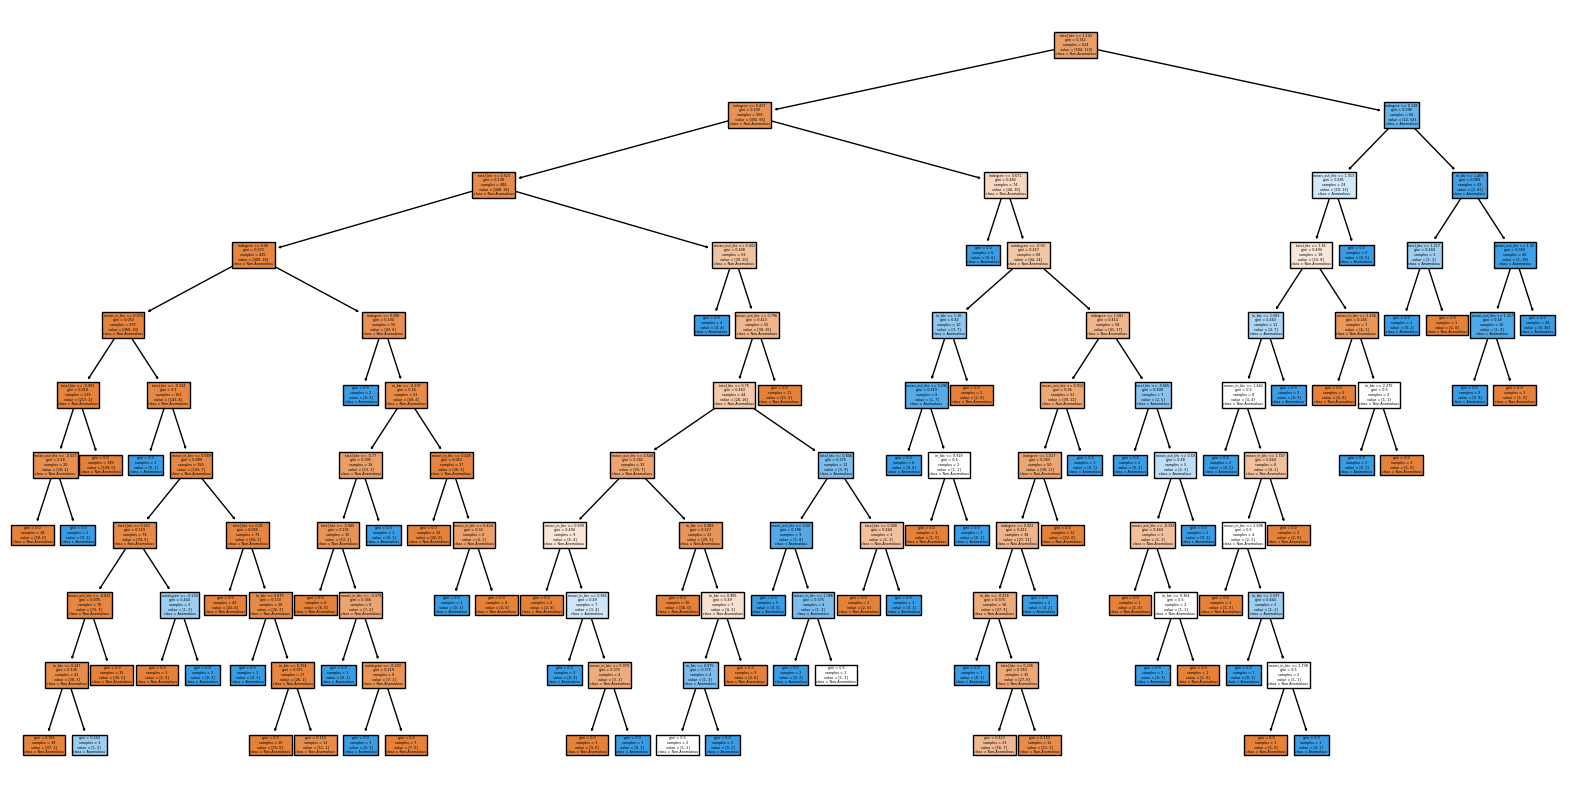

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Plot the decision tree
plt.figure(figsize=(20,10))
plot_tree(clf, feature_names=features.columns, class_names=['Non-Anomalous', 'Anomalous'], filled=True)
plt.show()


**Very low total bitcoins.

Unusual patterns in the number of incoming and outgoing transactions.

High average amounts of bitcoins received or sent.

Specific combinations of the above metrics.**

#save model

In [ ]:
# prompt: save model

import joblib
import os


# Define the path where you want to save the model
model_path = os.path.join('/content/gdrive/My Drive/Colab Notebooks/FYP/Models', 'model.joblib')

# Save the model
joblib.dump(voting_clf_soft, model_path)


['/content/gdrive/My Drive/Colab Notebooks/FYP/Models/model.joblib']

#Load Model


In [ ]:
!pip install scikit-learn==1.0.2 joblib==1.1.0

In [ ]:
import joblib
import os

# Load the model from the specified path
model_path = os.path.join('/content/gdrive/My Drive/Colab Notebooks/FYP/Models', 'model.joblib')
model = joblib.load(model_path)


#fetch data from blockchain

In [ ]:
!pip install web3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.5/515.5 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of eth-account to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of eth-rlp to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.4/355.4 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.0/96.0 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.3/309.3 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.3/288.3 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install eth-abi --upgrade

In [ ]:
from web3 import Web3
import json
from web3.middleware import geth_poa_middleware
from eth_abi import decode

# Connect to Infura node
infura_url = 'https://polygon-amoy.infura.io/v3/eacc339c13ac49aabc1ea5954e9bc26c'
web3 = Web3(Web3.HTTPProvider(infura_url))

# Inject the POA compatibility middleware
web3.middleware_onion.inject(geth_poa_middleware, layer=0)

if not web3.is_connected():
    print("Failed to connect to the Ethereum network")
else:
    print("Connected to the Ethereum network")

contract_abi = [
	{
		"anonymous": False,
		"inputs": [
			{
				"indexed": False,
				"internalType": "address",
				"name": "sender",
				"type": "address"
			},
			{
				"indexed": False,
				"internalType": "address",
				"name": "receiver",
				"type": "address"
			},
			{
				"indexed": False,
				"internalType": "uint256",
				"name": "amount",
				"type": "uint256"
			},
			{
				"indexed": False,
				"internalType": "bytes32",
				"name": "txHash",
				"type": "bytes32"
			}
		],
		"name": "TransactionRecorded",
		"type": "event"
	},
	{
		"inputs": [
			{
				"internalType": "address",
				"name": "receiver",
				"type": "address"
			},
			{
				"internalType": "uint256",
				"name": "amount",
				"type": "uint256"
			}
		],
		"name": "recordTransaction",
		"outputs": [],
		"stateMutability": "nonpayable",
		"type": "function"
	}
]

# Create contract instance
contract_address = '0xd8b934580fcE35a11B58C6D73aDeE468a2833fa8'  # Replace with the actual contract address
contract = web3.eth.contract(address=contract_address, abi=contract_abi)


def bigint_replacer(obj):
    if isinstance(obj, (int, float)):
        return str(obj)

def decode_log(log, abi):
    """Decode a log using ABI"""
    topic_0 = log['topics'][0].hex()
    event_abi = next(e for e in abi if e['type'] == 'event' and Web3.keccak(text=e['name'] + '(' + ','.join(i['type'] for i in e['inputs']) + ')').hex() == topic_0)
    data_types = [i['type'] for i in event_abi['inputs']]
    decoded_data = decode(data_types, bytes.fromhex(log['data'].hex()[2:]))
    decoded_log = {i['name']: decoded_data[idx] for idx, i in enumerate(event_abi['inputs'])}
    return decoded_log

def get_transaction_metadata(tx_hash):
    try:
        receipt = web3.eth.get_transaction_receipt(tx_hash)
        if receipt is None:
            print("Transaction receipt not found!")
            return None
        transaction = web3.eth.get_transaction(tx_hash)
        block = web3.eth.get_block(transaction.blockNumber)

        inputs = [{
            'address': transaction['from'],
            'value': web3.from_wei(transaction['value'], 'ether')
        }]

        outputs = []
        try:
            for log in receipt['logs']:
                # Decode only logs related to the TransactionRecorded event
                if log['topics'][0].hex() == Web3.keccak(text="TransactionRecorded(address,address,uint256,bytes32)").hex():
                    decoded_log = decode_log(log, contract_abi)
                    if 'txHash' in decoded_log:
                        decoded_log['txHash'] = decoded_log['txHash'].hex()
                    outputs.append(decoded_log)
        except Exception as e:
            print(f"Error decoding log: {e}")

        metadata = {
            'from': transaction['from'],
            'to': transaction['to'],
            'value': web3.from_wei(transaction['value'], 'ether'),
            'gasUsed': str(receipt['gasUsed']),
            'blockNumber': str(transaction['blockNumber']),
            'timestamp': str(block['timestamp']),
            'inputs': inputs,
            'outputs': outputs
        }
        return metadata
    except Exception as error:
        print('Error fetching transaction metadata:', error)

# Example transaction hash (you can replace this with any valid transaction hash)
tx_hash = '0xe2938db0c9c1554fc9f01615441e501f52b7af46d845ca62cdc757cb8edfaca5'

metadata = get_transaction_metadata(tx_hash)
if metadata:
    print(json.dumps(metadata, default=bigint_replacer, indent=4))
else:
    print("Transaction metadata not found")


Connected to the Ethereum network
{
    "from": "0xda9ACf3E391a96DA1A60Fa3aBdF55275834a1157",
    "to": "0x3869193fdf78000eb8Ef14E90376ab7d8D907799",
    "value": 0,
    "gasUsed": "25379",
    "blockNumber": "9833789",
    "timestamp": "1721739744",
    "inputs": [
        {
            "address": "0xda9ACf3E391a96DA1A60Fa3aBdF55275834a1157",
            "value": 0
        }
    ],
    "outputs": [
        {
            "sender": "0xda9acf3e391a96da1a60fa3abdf55275834a1157",
            "receiver": "0x0000000000000000000000000000000000000000",
            "amount": 10000000000,
            "txHash": "8d7d18b022c30181daf4998a708f25196cd275f97e7abffc96332087ee77fb11"
        }
    ]
}


#Preprocess Transaction data

In [ ]:
# transactions =[
#    {
#     "from": "0xda9acf3e391a96da1a60fa3abdf55275834a1157",
#     "to": "0x3869193fdf78000eb8ef14e90376ab7d8d907799",
#     "value": "0.",
#     "gasUsed": "25379",
#     "blockNumber": "9833789",
#     "timestamp": "1721739744",
#     "inputs": [
#         {
#             "address": "0xda9acf3e391a96da1a60fa3abdf55275834a1157",
#             "value": "0."
#         }
#     ],
#     "outputs": [
#         {
#             "address": "0x0000000000000000000000000000000000000000",
#             "amount": "0.00000001"
#         },
#         {
#             "address": "0x00000000000000000000000001b2a0012c28eA78",
#             "amount": "12745.882748422369400056"
#         }
#     ]
# }
# ]

In [ ]:
transactions = metadata

In [ ]:
import pandas as pd

def preprocess_transaction(tx):
    features = {}

    # Calculate indegree and outdegree
    features['indegree'] = len(tx['inputs'])
    features['outdegree'] = len(tx['outputs'])

    # Calculate in_btc, out_btc, total_btc, mean_in_btc, mean_out_btc
    # Convert string values to floats before summing
    features['in_btc'] = sum(float(input['value']) for input in tx['inputs'])
    out_btc = sum(float(output['amount']) for output in tx['outputs'])
    features['total_btc'] = out_btc - features['in_btc']
    features['mean_in_btc'] = features['in_btc'] / features['indegree'] if features['indegree'] > 0 else 0
    features['mean_out_btc'] = out_btc / features['outdegree'] if features['outdegree'] > 0 else 0

    return features

def preprocess_transactions(transactions):
    if not isinstance(transactions, list):
        transactions = [transactions]
    preprocessed_data = [preprocess_transaction(tx) for tx in transactions]
    return pd.DataFrame(preprocessed_data)



# Preprocess the transactions
preprocessed_df = preprocess_transactions(transactions)
print(preprocessed_df)


   indegree  outdegree  in_btc     total_btc  mean_in_btc  mean_out_btc
0         1          1     0.0  1.000000e+10          0.0  1.000000e+10


In [ ]:
# Make predictions
predictions = model.predict(preprocessed_df)
print(predictions)

[0]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(


#Predict Using the model

### Scenario 1: Low Activity, Small Transactions


In [ ]:
metadata = {
    "indegree": 1,
    "outdegree": 1,
    "in_btc": 0.02,
    "total_btc": 0.005,
    "mean_in_btc": 0.02,
    "mean_out_btc": 0.015
}

metadata_df = pd.DataFrame([metadata])  # Encapsulate metadata in a list for DataFrame creation


In [ ]:
# Make predictions
predictions = model.predict(metadata_df)
print(predictions)

[0]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(


** This low activity with small amounts looks like a typical, harmless user behavior, like someone casually using the platform.**



###Scenario 2: Moderate Activity, Moderate Transactions


In [ ]:
metadata = {
    "indegree": 3,
    "outdegree": 2,
    "in_btc": 0.15,
    "total_btc": 0.05,
    "mean_in_btc": 0.05,
    "mean_out_btc": 0.05
}
metadata_df = pd.DataFrame([metadata])  # Encapsulate metadata in a list for DataFrame creation

In [ ]:
# Make predictions
predictions = model.predict(metadata_df)
print(predictions)

[0]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(


This moderate activity with moderate amounts is normal, like a user making regular transactions or investments.


###Scenario 3: Very High Activity, Very Large Transactions


In [ ]:
metadata = {
    "indegree": 50,
    "outdegree": 45,
    "in_btc": 100.0,
    "total_btc": 10.0,
    "mean_in_btc": 2.0,
    "mean_out_btc": 2.0
}
metadata_df = pd.DataFrame([metadata])  # Encapsulate metadata in a list for DataFrame creation

In [ ]:
# Make predictions
predictions = model.predict(metadata_df)
print(predictions)

[1]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(


Reason: Picture a scenario where a lot of money is moved rapidly between different accounts. This can be like someone trying to hide where the money originally came from, making it hard to track.



###Scenario 4: Large Incoming Transactions, Low Outgoing Transactions


In [ ]:
metadata = {
    "indegree": 50,
    "outdegree": 1,
    "in_btc": 100.0,
    "total_btc": 98.0,
    "mean_in_btc": 98.0,
    "mean_out_btc": 2.0
}
metadata_df = pd.DataFrame([metadata])  # Encapsulate metadata in a list for DataFrame creation

In [ ]:
# Make predictions
predictions = model.predict(metadata_df)
print(predictions)

[1]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(


Reason:
market manipulation
